# Import packages & dataset, Data preprocessing

In [1]:
### Import Packages will be used
import sklearn
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf
import math
import itertools
import matplotlib.pyplot as plt

### Load dataset, text preprocessing, prepare train data, valid data & test data
#### Fetch 20 newsgroups Dataset (all) & Text preprocessing
def load_data():
    ##### import and filter data
    newsgroups = fetch_20newsgroups(subset = "all", remove = ("headers", "footers", "quotes"))
    ##### Remove headers, footers and quotes 
    ##### as they have too much information about the association between documents
    texts_all, y_all = newsgroups.data, newsgroups.target
    return texts_all, y_all

#### Text preprocessing
download("punkt")
download("stopwords")
stop_words = stopwords.words("english")
def text_preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc

#### Removing empty or meaningless emails
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus, texts and labels given the function condition_on_doc which takes a doc.
    The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))
    return (corpus, texts, labels)

#### Determine the number of features in preprocessed data
def get_features(texts):
    # Bag-of-words representation
    bow_vectorizer = CountVectorizer()
    bow_all = bow_vectorizer.fit_transform(texts) 
    bow_shape_all = bow_all.shape
    bow_feature_names = bow_vectorizer.get_feature_names()
    #print("{} all data points.".format(bow_shape_all[0]))
    #print("{} feature dimension.".format(bow_shape_all[1]))
    return bow_all, bow_feature_names

#### One hot encoding
def onehot_encode(labels):
    values = np.array(labels)
    values = values.reshape(len(values), 1)
    onehot_encoder = OneHotEncoder(sparse = False)
    onehot_encoded = onehot_encoder.fit_transform(values)
    return onehot_encoded

#### Contruct binary matrix 
def get_binary_matrix(corpus_matrix):
    n, p = corpus_matrix.shape
    binary_matrix = np.zeros((n, p))
    for i in range(n):
        for j in range(p):
            binary_matrix[i, j] = 0 if corpus_matrix[i, j] == 0 else 1
    return binary_matrix

#### Construct P matrix & normalize it
def get_p_matrix(feature_matrix, top):
    sorted_matrix = np.sort(feature_matrix)
    top_list = sorted_matrix[:, -top]
    n = feature_matrix.shape[0]
    p_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if feature_matrix[i, j] >= max(top_list[i], 0.10):
                p_matrix[i, j] = feature_matrix[i, j]
            else:
                p_matrix[i, j] = 0
    p_matrix = p_matrix - np.eye(n)
    return(p_matrix)

def normalize(p_matrix):
    norm = np.linalg.norm(p_matrix)
    if norm == 0: 
        return p_matrix
    return p_matrix/norm

#### Obtain all datasets and matrix required for model training step
def data_preprocessed():
    texts_all, y_all = load_data()
    corpus_all = [text_preprocess(text) for text in texts_all]
    corpus_all, texts_all, y_all = filter_docs(corpus_all, texts_all, y_all, lambda doc: (len(doc) != 0))
    bow_all, bow_feature_names = get_features(texts_all)
    mask = bow_all.sum(axis = 0) >= 20
    mask = np.array(mask).ravel()
    bow_all_20 = bow_all[:, mask].toarray()
    word_count_20 = np.log(bow_all_20 + 1)
    return y_all, bow_all_20, word_count_20
y_all, bow_all_20, word_count_20 = data_preprocessed()

def data_management():
    y_onehot = onehot_encode(y_all)
    binary_matrix = get_binary_matrix(bow_all_20.T)
    #### Obtain similarity between any two features
    features = cosine_similarity(binary_matrix, binary_matrix)
    p_matrix = get_p_matrix(features, 26)
    normalized_p_matrix = normalize(p_matrix)
    return y_onehot, features, normalized_p_matrix
y_onehot, features, normalized_p_matrix = data_management()

def data_split(numEntries, numList, seed):
    random.seed(seed)  #### To make sure the result is reproducable
    selected = np.copy(random.sample(range(numEntries), numList))
    NG20_X, NG20_Y = word_count_20[selected, :], y_onehot[selected, :]
    trainX, testX, trainY, testY = train_test_split(NG20_X, NG20_Y, test_size = 0.2, random_state = 18)
    return NG20_X, NG20_Y, trainX, testX, trainY, testY
  

numEntries = len(y_all)
numList = 2500
trainvalidX, trainvalidY, trainX, testX, trainY, testY = data_split(numEntries = numEntries, 
                                                                    numList = numList, 
                                                                    seed = 2018)
print(trainvalidX.shape)
print(trainvalidY.shape)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


[nltk_data] Downloading package punkt to /Users/veronica/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/veronica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
555 docs removed
(2500, 11961)
(2500, 20)
(2000, 11961)
(2000, 20)
(500, 11961)
(500, 20)


# Training model by minimizing the following loss function
\begin{equation} \label{eq:loss} 
loss(\mathbf{w}) = \sum_{i = 1}^{n}l(\mathbf{x_{i}, y_{i}}; \mathbf{w})
						   + \alpha\sum_{j = 1}^{p}\big(\mathbf{w_{j}} - \sum_{k}P_{jk}\mathbf{w_k} \big)^2 
						   + \beta||\mathbf{w}||_{2}^{2}
\end{equation}

##### In this part, the accuracy was defined, which actually means the proportion of true positives

In [2]:
numFeatures = features.shape[0]
numLabels = 20
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == 
            np.argmax(labels, 1))/predictions.shape[0])

def network_norm2(trainX, trainY, testX, testY, alpha, beta):
    graph = tf.Graph()
    with graph.as_default():
        ### Input data (constants)
        tf_trainX = tf.constant(trainX, dtype = "float32")
        tf_trainY = tf.constant(trainY, dtype = "float32")
        tf_testX = tf.constant(testX, dtype = "float32")
        
        ### Set variables
        weights = tf.Variable(tf.truncated_normal([numFeatures, numLabels]))
        biases = tf.Variable(tf.zeros([numLabels]))
    
        ### Training computation
        logits = tf.matmul(tf_trainX, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_trainY, logits = logits))
    
        ### Network Penalty
        network = tf.matmul(weights, tf.cast(np.eye(numFeatures) - normalized_p_matrix, tf.float32), 
                            transpose_a = True, transpose_b = True)
        regularizer_Network = tf.nn.l2_loss(network)
        ### Loss function using L2 Regularization
        regularizer_L2 = tf.nn.l2_loss(weights)
        loss = tf.reduce_mean(loss + alpha * regularizer_Network + beta * regularizer_L2)
    
        optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(tf.matmul(tf_testX, weights) + biases)
        
    with tf.Session(graph = graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(1000):
            _, l, predictions = session.run([optimizer, loss, train_prediction])
            if step % 100 == 0:
                print("Loss at step {}: {}".format(step, l))
                print("Training accuracy: {:.1f}".format(accuracy(predictions, trainY)))
                print("Validation/Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), testY)))
        train_acc = accuracy(predictions, trainY)
        test_acc = accuracy(test_prediction.eval(), testY)
    return train_acc, test_acc

# Conduct 5-fold cross validation to determine the hyperparameters

In [ ]:
def get_hyper(base, lower, upper, step):
    power = np.arange(lower, upper, step)
    hyper_list = []
    L = upper - lower
    for p in power:
        hyper = math.pow(base, p)
        hyper_list.append(hyper)
    alpha = list(itertools.chain.from_iterable(itertools.repeat(x, L) for x in hyper_list))
    beta = hyper_list * L
    hyper_parameter = np.vstack((alpha, beta))
    return hyper_parameter

#hyper_parameter = get_hyper(2, -10, 11, 1)
hyper_parameter = get_hyper(10, -4, 0, 1)

def do_k_fold(trainvalidX, trainvalidY, model, hyper_parameter):
    average_accuracy_cross_folds = []
    for i in range(np.shape(hyper_parameter)[1]):
        print("k-fold loop index is: {}".format(i))
        kf = KFold(n_splits = 5, shuffle = False)
        print("split number is: {}".format(kf.get_n_splits(trainvalidX)))
        train_acc_list = []
        valid_acc_list = []
        fold_num = 0
        #### Loop over folds
        for train_index, valid_index in kf.split(trainvalidX):
            fold_num += 1
            print("fold number is: {}".format(fold_num))
            trainX, validX = trainvalidX[train_index], trainvalidX[valid_index]
            trainY, validY = trainvalidY[train_index], trainvalidY[valid_index]
            train_acc, valid_acc = network_norm2(trainX, trainY, validX, validY, 
                                                 alpha = hyper_parameter[0, i], 
                                                 beta = hyper_parameter[1, i])
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
        
        average_accuracy_cross_folds.append(np.mean(valid_acc_list))
    print("average accuracies are: {}".format(average_accuracy_cross_folds))
    opt_index = np.argmax(average_accuracy_cross_folds)
    return hyper_parameter[:, opt_index], np.take(average_accuracy_cross_folds, opt_index)
  
best_k_index, best_valid_accuracy = do_k_fold(trainvalidX, trainvalidY, network_norm2, hyper_parameter)


# By above step, we got following values:
#### best_k_index: array([0.0001, 0.001 ])
#### best_valid_accuracy: 48.92
# Redefine the model to create confusion matrix:

In [3]:
def network_norm2_update(trainX, trainY, testX, testY, alpha, beta):
    graph = tf.Graph()
    with graph.as_default():
        ### Input data (constants)
        tf_trainX = tf.constant(trainX, dtype = "float32")
        tf_trainY = tf.constant(trainY, dtype = "float32")
        tf_testX = tf.constant(testX, dtype = "float32")
        
        ### Set variables
        weights = tf.Variable(tf.truncated_normal([numFeatures, numLabels]))
        biases = tf.Variable(tf.zeros([numLabels]))
    
        ### Training computation
        logits = tf.matmul(tf_trainX, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_trainY, logits = logits))
    
        ### Network Penalty
        network = tf.matmul(weights, tf.cast(np.eye(numFeatures) - normalized_p_matrix, tf.float32), 
                            transpose_a = True, transpose_b = True)
        regularizer_Network = tf.nn.l2_loss(network)
        ### Loss function using L2 Regularization
        regularizer_L2 = tf.nn.l2_loss(weights)
        loss = tf.reduce_mean(loss + alpha * regularizer_Network + beta * regularizer_L2)
    
        optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(tf.matmul(tf_testX, weights) + biases)
        
    with tf.Session(graph = graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(1000):
            _, l, predictions = session.run([optimizer, loss, train_prediction])
            if step % 100 == 0:
                print("Loss at step {}: {}".format(step, l))
                print("Training accuracy: {:.1f}".format(accuracy(predictions, trainY)))
                print("Validation/Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), testY)))
        train_acc = accuracy(predictions, trainY)
        test_acc = accuracy(test_prediction.eval(), testY)
        cls_y = testY.argmax(1)
        cls_yhat = test_prediction.eval().argmax(1)
    return train_acc, test_acc, cls_y, cls_yhat

train_acc, test_acc, cls_y, cls_yhat = network_norm2_update(trainX, trainY, testX, testY, 
                                                            alpha = 0.0001, beta = 0.001)

#train_acc, test_acc, cls_y, cls_yhat = network_norm2_update(trainX, trainY, testX, testY, 
#                                                            alpha = best_k_index[0], beta = best_k_index[1])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Initialized
Loss at step 0: 113.43694305419922
Training accuracy: 5.5
Validation/Test accuracy: 15.2
Loss at step 100: 1.4227286577224731
Training accuracy: 95.2
Validation/Test accuracy: 45.6
Loss at step 200: 2.5290682315826416
Training accuracy: 90.1
Validation/Test accuracy: 41.2
Loss at step 300: 1.155403733253479
Training accuracy: 97.5
Validation/Test accuracy: 48.8
Loss at step 400: 2.9868111610412598
Training accuracy: 85.9
Validation/Test accuracy: 43.6
Loss at step 500: 1.63816499710083
Training accuracy: 93.1
Validation/Test accuracy: 49.0
Loss at step 600: 1.2645134925842285
Training accuracy: 96.8
Validation/Test accuracy: 45.8
Loss at step 700: 1.2323973178863525
Training accuracy: 96.0
Validation/Test accuracy: 48.4
Loss at step 800: 1.365545392036438
Training accuracy: 96.8
Validatio

# Following codes were used to generate confusion matrix:

Confusion matrix, without normalization
[[ 3  0  0  0  0  0  1  1  0  1  0  0  0  0  0  5  0  0  3  0]
 [ 0 14  1  2  0  2  1  0  0  0  0  0  1  0  1  0  0  0  1  0]
 [ 2  6 14  3  0  2  1  0  1  0  0  1  1  0  0  1  0  0  1  0]
 [ 1  3  1 12  0  2  1  0  0  0  0  0  0  1  1  0  0  0  2  0]
 [ 2  1  1  3  9  0  2  0  1  0  0  0  0  0  0  0  0  0  3  0]
 [ 1  4  4  1  1  9  2  0  1  0  0  1  1  0  0  0  0  0  2  0]
 [ 0  0  0  1  0  0 18  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  1  0  1  2  1 11  1  1  0  0  2  1  3  0  0  1  0  0]
 [ 2  1  0  0  0  2  2  4 24  1  0  0  1  1  3  3  0  0  2  0]
 [ 0  1  0  0  1  0  3  0  0 10  1  1  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0  1  1  2  1  4 15  0  1  0  1  4  0  0  1  1]
 [ 2  2  1  0  0  0  0  0  0  1  0  9  0  1  1  4  0  1  1  0]
 [ 1  0  1  1  2  1  1  0  0  1  0  0  7  3  2  3  0  0  0  0]
 [ 2  1  0  0  0  0  1  0  4  2  0  0  0 10  2  6  0  0  3  1]
 [ 1  1  0  0  0  1  0  1  3  1  0  0  2  0 10  3  1  0  2  0]
 [ 1  0  0  0  

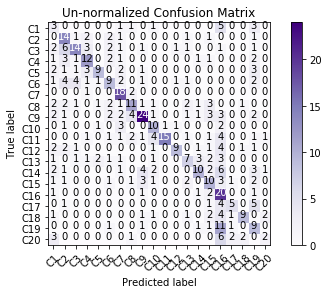

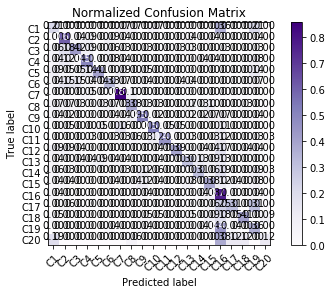

In [4]:
cnf_matrix = confusion_matrix(cls_y, cls_yhat)
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion Matrix", cmap = plt.cm.Purples):
    if normalize:
        cm = cm.astype("float")/cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

class_names = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10",
               "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20"]     

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = "Un-normalized Confusion Matrix")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = True, title = "Normalized Confusion Matrix")
plt.show()

# Calculate average accuracy of each class, in which the accuracy was defined as $accuracy = \frac{TPs + TNs}{Total}$

In [5]:
def get_average_accuracy(cm):
    TPs = []
    TNs = []
    accuracys = []
    sums = np.sum(cm)
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        TN = sums - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        accuracy = (TP + TN)/sums
        TPs = np.append(TPs, TP)
        TNs = np.append(TNs, TN)
        accuracys = np.append(accuracys, accuracy)
        avg_acc = np.mean(accuracys)
    return avg_acc

avg_acc = get_average_accuracy(cnf_matrix)
print(avg_acc)

0.9440000000000002
